## Общая информация

**Срок сдачи:** 5 апреля 2022, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import  fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier, KDTree
from sklearn.metrics import accuracy_score, pairwise_distances

### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute'):
        self.n = n_neighbors
        self.algorithm = algorithm

    def cross_val(self, X, y, metric = 'euclidean', n_splits = 3, nn_max = 10):
        self.c_X = X
        self.c_y = y
        self.n = n_splits
        self.max = nn_max
        history = np.zeros(self.max)
        kf = KFold(self.n, shuffle=True, random_state=10)
        for train_index, test_index in kf.split(self.c_X):
            dist = pairwise_distances(self.c_X[train_index], self.c_X[test_index], metric = metric)
            index_of_n_nearest = np.argpartition(dist, np.arange(self.max), axis=1)[:, :self.max]
            for i in np.arange(self.max):
                i_nearest = self.c_y[train_index][index_of_n_nearest[:,:i + 1]]
                pred = np.zeros(test_index.shape[0])
                for j in np.arange(test_index.shape[0]):
                    pred[j] = np.bincount(i_nearest[j]).argmax()
                history[i] += accuracy_score(pred, self.c_y[test_index])
        return history / self.n

    def fit(self, X, y):
        self.X_train, self.y_train =X, y
        if self.algorithm == "kd_tree":
             self.kd_tree = KDTree(X_train)
    
    def predict(self, X, metric = 'euclidean'):
        if self.algorithm == 'brute':
            dist = pairwise_distances(X, self.X_train, metric = metric)
            index_of_n_nearest = np.argpartition(dist, np.arange(self.n), axis=1)[:, :self.n]
            y_n = self.y_train[index_of_n_nearest]
            pred = np.zeros(X.shape[0], dtype=np.int16)
            for i in np.arange(X.shape[0]):
                pred[i] = np.bincount(y_n[i]).argmax()
        
        if self.algorithm == "kd_tree":
            dist, ind = self.kd_tree.query(X, k = 2)
            k_neighbors = self.y_train[ind]
            pred = np.zeros(X.shape[0], dtype = np.int16)
            for i in np.arange(X.shape[0]):
                pred[i] = np.bincount(k_neighbors[i]).argmax()
        return pred

    

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

In [8]:
my_clf_pred = my_clf.predict(X_test)
my_clf_pred

array([1, 1, 1, 2, 0, 1, 0, 2, 2, 2, 1, 1, 0, 0, 0], dtype=int16)

### Задание 2 (0.5 балла)

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [9]:
%time clf.fit(X_train, y_train)

CPU times: user 650 µs, sys: 150 µs, total: 800 µs
Wall time: 722 µs


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [10]:
%time my_clf.fit(X_train, y_train)

CPU times: user 7 µs, sys: 1e+03 ns, total: 8 µs
Wall time: 13.1 µs


In [11]:
%time clf.predict(X_test)

CPU times: user 3.35 ms, sys: 2.61 ms, total: 5.95 ms
Wall time: 3.73 ms


array([1, 1, 1, 2, 0, 1, 0, 2, 2, 2, 1, 1, 0, 0, 0])

In [12]:
%time my_clf.predict(X_test)

CPU times: user 874 µs, sys: 358 µs, total: 1.23 ms
Wall time: 961 µs


array([1, 1, 1, 2, 0, 1, 0, 2, 2, 2, 1, 1, 0, 0, 0], dtype=int16)

### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [13]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [14]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [15]:
%time clf.fit(X_train, y_train)

CPU times: user 1.36 ms, sys: 1.6 ms, total: 2.96 ms
Wall time: 3.54 ms


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [16]:
%time my_clf.fit(X_train, y_train)

CPU times: user 229 µs, sys: 31 µs, total: 260 µs
Wall time: 244 µs


In [17]:
%time clf.predict(X_test)

CPU times: user 2.55 ms, sys: 1.21 ms, total: 3.76 ms
Wall time: 3.37 ms


array([0, 1, 1, 0, 0, 2, 1, 1, 2, 2, 2, 0, 1, 1, 0])

In [18]:
%time my_clf.predict(X_test)

CPU times: user 950 µs, sys: 992 µs, total: 1.94 ms
Wall time: 1.21 ms


array([0, 1, 1, 0, 0, 2, 1, 1, 2, 2, 2, 0, 1, 1, 0], dtype=int16)

In [19]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

### Задание 4 (2.5 балла)

Рассмотрим новый датасет 20 newsgroups

In [20]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [21]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [22]:
vectorizer = CountVectorizer(max_features=71018)
X_train = vectorizer.fit_transform(data)
y_train = target

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

>>sklearn.cross_validation is not active, I realize my own method "cross_val"" of class MyKNeighborsClassifier

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

Text(0, 0.5, 'Mean accuracy')

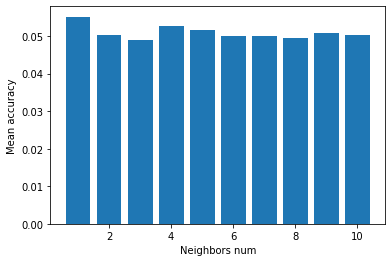

In [23]:
my_clf = MyKNeighborsClassifier(n_neighbors=10)
plt.bar(np.arange(10)+1, my_clf.cross_val(X_train, y_train, n_splits=3))
plt.xlabel("Neighbors num")
plt.ylabel("Mean accuracy")

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [26]:
X_train = TfidfVectorizer(max_features=71018).fit_transform(newsgroups['data'])
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [27]:
my_clf = MyKNeighborsClassifier(n_neighbors=4)
my_clf.fit(X_train, y_train)
X_test = TfidfVectorizer(max_features=71018).fit_transform(newsgroups['data'])
y_test = newsgroups['target']
accuracy_score(y_test, my_clf.predict(X_test, metric='cosine'))

0.062002124269782265

>>TfidfVectorizer was used separately for X_test and X_train samples -> accuracy very low